In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import numpy as np
import os
from IPython.display import Image as Image2
from numpy import genfromtxt
import pickle
from IPython import embed
from PIL import Image, ImageDraw, ImageFont
from scipy.io import loadmat

import seaborn as sns
import pandas as pd
%matplotlib inline
from scipy import ndimage
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.patches as mpatches

In [2]:
my_data = genfromtxt('../data/sperm-whale-dialogues.csv',delimiter=',',dtype=None,encoding="utf8")
my_data[0,:],my_data.shape

(array(['REC', 'nClicks', 'Duration', 'ICI1', 'ICI2', 'ICI3', 'ICI4',
        'ICI5', 'ICI6', 'ICI7', 'ICI8', 'ICI9', 'ICI10', 'ICI11', 'ICI12',
        'ICI13', 'ICI14', 'ICI15', 'ICI16', 'ICI17', 'ICI18', 'ICI19',
        'ICI20', 'ICI21', 'ICI22', 'ICI23', 'ICI24', 'ICI25', 'ICI26',
        'ICI27', 'ICI28', 'Whale', 'TsTo'], dtype='<U15'),
 (3841, 33))

In [3]:
# Parses, cleans and orders the annotations in the order of appearence of the clicks

# Initializes a dictionary annotations:
# Where the Keys : Names of the Audio Files
# Values : empty lists
annotations = {}
for i in range(1,my_data.shape[0]):
    file_name = str(my_data[i,0][:9]) # Only the first 9 characters if the file names in the annotation correpond to the file names we have in the dataset
    annotations[file_name] = []



# Then we go over the entries of the annotation file one by one (row wise) and append the annotation to the list corresponding to the file name
# The annotations are not ordered in time in the annotation file so it is a random order.

for i in range(1,my_data.shape[0]):
    file_name = str(my_data[i,0][:9]) # Only first 9 characs is file name
    time_start = float(my_data[i,-1]) # 48 entry is the start time of the first click of the coda seq
    # collect all files with that name
    temp = [] # List of times the clicks of the codas lie at - (t1-t1),(t2-t1),(t3-t1)...
    temp.append(0)
    j = 3
    while (float(my_data[i,j]) != 0 and j<31): # Until the value of the ICI is zero we continue to append (tn-t1)
        if float(my_data[i,j])> 0.0002: # To ignore mistakes in annotations
            temp.append(0+np.sum(my_data[i,3:(j+1)].astype(float))) # t3-t1 = (t3-t2)+(t2-t1) = ICI2+ICI1
            # temp.append(my_data[i,j].astype(float))
        j = j+1
    annotations[file_name].append([temp,time_start,int(my_data[i,-2]),0]) #Coda seq, what_time, what_whale_number


#annotation is now a dict of annotations but is still not ordered in time
# Convert the dict of lists into a list of numpy array
books = []
for key in annotations.keys():
    story = annotations[key] #each entity is a line of a coda
    book = np.zeros((len(story),44))
    for j in range(len(story)):
        book[j,0] = story[j][2] # Who made the sound (ID number)
        book[j,1] = story[j][1] # What time did it start at
        book[j,2:len(story[j][0])+2] = story[j][0] # Coda sequence
        book[j,43] = story[j][-1] # Labels
    books.append((book,key))




# Sorts the annotation arrays of each audio file in order of time
edited = []
for i in range(len(books)):
    book = books[i][0]
    sorted_array = book[np.argsort(book[:, 1])]
    edited.append((sorted_array,books[i][1]))


#edited = [(annotations_1,filename_1),(annotations_2,filename_2)...]
# where annotations_i : Numpy array of shape -> (total codas, 44)
# 0th column : ID of whale that made the coda
# 1st colum  : What absolute time in the file did the coda start at?
# 2nd column to 42nd column: Time from the first click the jth click of the coda occurs at.
# filename_i : Name of the audio file

In [4]:
# Make the plots

In [5]:
# Change this value depending on how many audiofiles you want to see plotted (one audio file may be split into several pages)
num_audiobooks = len(edited) # max value it can take = len(edited)
num_pdfs = 1

In [6]:
# CODA grouping parameters:
max_diff = 25 # Max time difference otherwise disconnect
max_diff = 15 # Max time difference otherwise disconnect
max_click_diff = 2 # Max  difference in the number of clicks, otherwise disconnect
# visualization parameters:
duration_page = 60*10 # seconds for the horizontal axis
duration_page = 60*3 # seconds for the horizontal axis
average_ICI = 0.2
duration_coda = 8*average_ICI # seconds for the vertical axis
left_margin_per_subplot = .1 # number of seconds
colour_chart = ['#7E2F8E','#77AC30','#D95319','#0072BD','r','g','b','c','m','y','k','#A2142F','#4DBEEE']
colour_chart = ['r','orange','steelblue','seagreen','y','m','c','#A2142F','#4DBEEE','#7E2F8E','#77AC30','#D95319','#0072BD']
number_of_subplots_per_page = 4

if not os.path.exists('../whalesbook'):
    os.mkdir('../whalesbook')


# Function: parse de coda and get basic info
def parseCoda(i):
    if i==-1:
        return [0,0,0,0,0]
    coda = book[i,:]
    whale_number = coda[0].astype(int)
    t_init = coda[1]-time_origin
    click_times = coda[2:42].astype(float).tolist()
    num_clicks = np.count_nonzero(click_times)+1 # sum 1 because the first click is always zero.
    click_times = click_times[0:num_clicks]
    label_ = coda[43].astype(int)
    return [whale_number,t_init,num_clicks,click_times,label_]#,average_power,click_power]

# Function: returns the index for the next coda (after coda i) from the same whale.
def getNextCoda(i, whale_number):
    found = -1
    while found==-1 and i<book.shape[0]-1:
        i=i+1
        [whale_number_i,t_init,num_clicks,click_times,label_] = parseCoda(i)
        if whale_number_i==whale_number:
            found = i
    return found

# Function: returns the index for the previous coda (before coda i) from the same whale.
def getPreviousCoda(i, whale_number):
    found = -1
    while found==-1 and i>0:
        i=i-1
        [whale_number_i,t_init,num_clicks,click_times,label_] = parseCoda(i)
        if whale_number_i==whale_number:
            found = i
    return found



----------------------------------------------------------------
idx: 0 File:sw061b001 Subplot=-1
   number of codas=220
  sw061b previous=
----------------------------------------------------------------
   time origin =126.0372
Splot of the conversation: 0
Splot of the conversation: 1
Splot of the conversation: 2
Splot of the conversation: 3
whalesbook/page_0.pdf
Splot of the conversation: 0
Splot of the conversation: 1
Splot of the conversation: 2
----------------------------------------------------------------
idx: 1 File:sw061b002 Subplot=2
   number of codas=290
  sw061b previous=sw061b
----------------------------------------------------------------
Splot of the conversation: 3
whalesbook/page_1.pdf
Splot of the conversation: 0
Splot of the conversation: 1
Splot of the conversation: 2
Splot of the conversation: 3
whalesbook/page_2.pdf
Splot of the conversation: 0
Splot of the conversation: 1
Splot of the conversation: 2
-----------------------------------------------------------

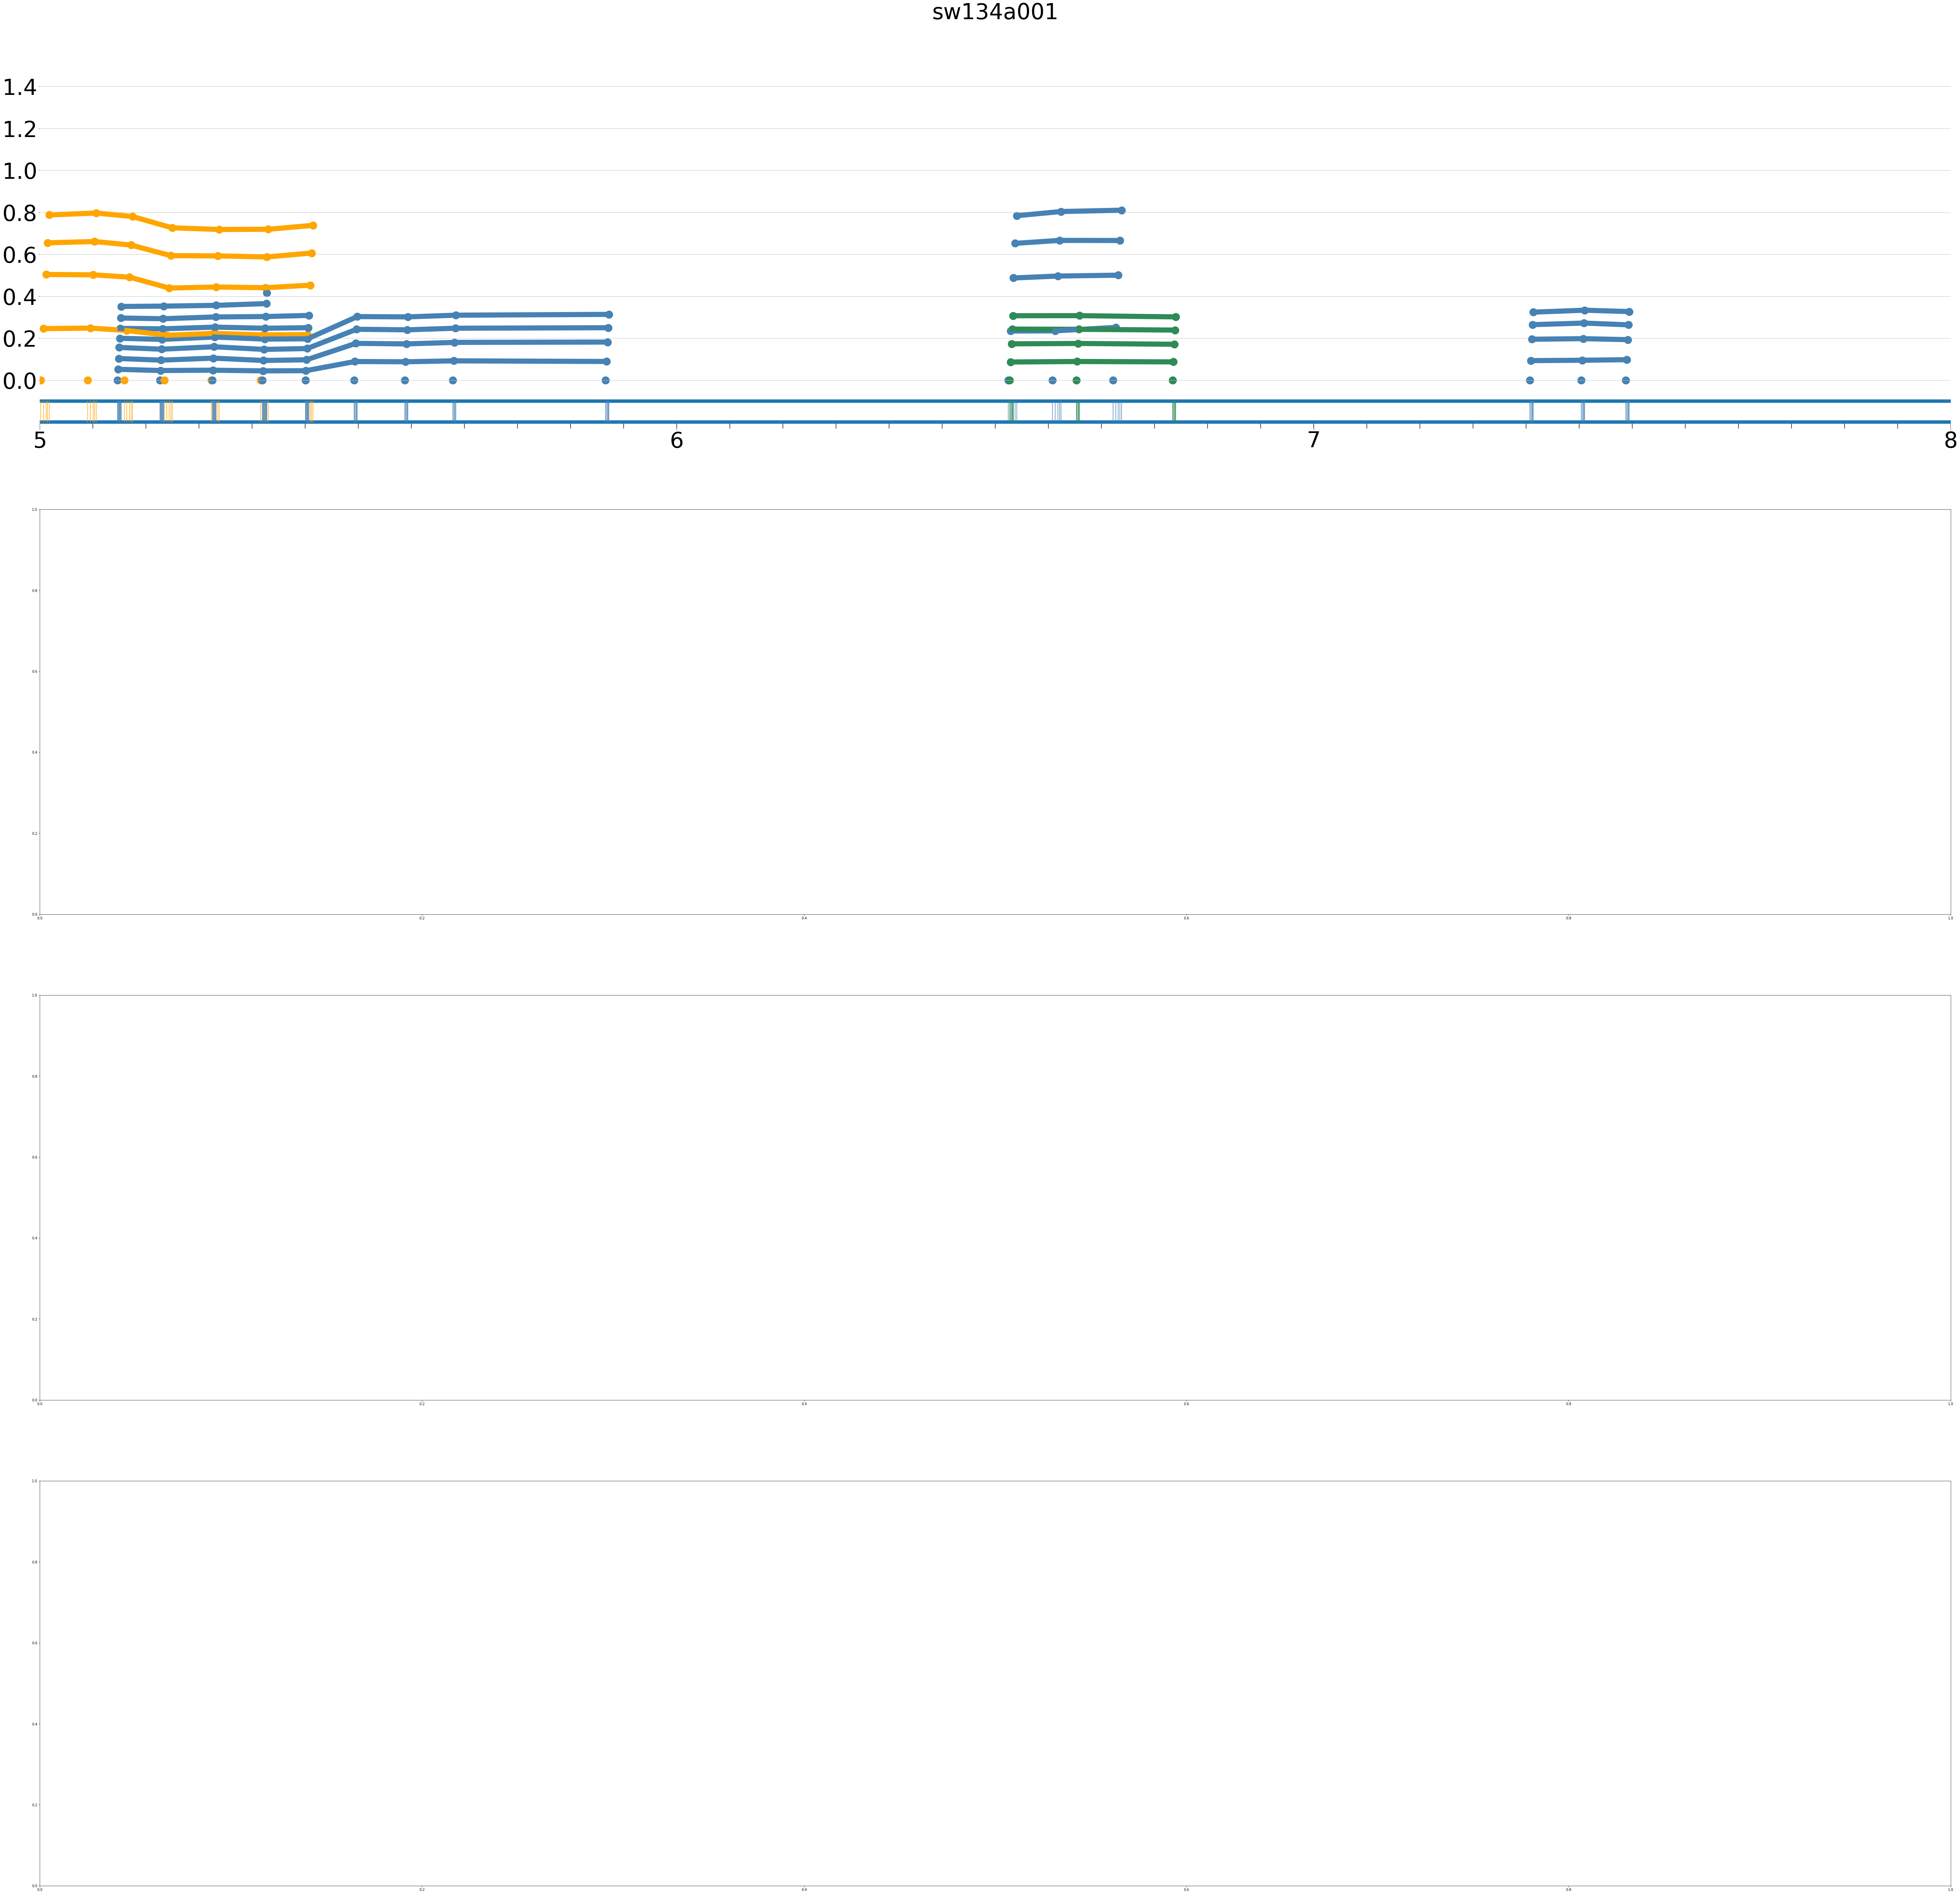

In [7]:
splot = -1
pdfnum = 0
previous_audiobook = ''
#book = edited[0][0]
#time_origin = book[0,1]
page_time_origin = -10000000000


colors_shade = ['r','g','b','orange','y']
    
newfile=0
starting_book =0
rootname='sw061b'

for idx in range(num_audiobooks):
    book = edited[idx][0]
    name = edited[idx][1]
    rootname = name[0:6]
    print("----------------------------------------------------------------")
    print('idx: '+str(idx)+' File:'+name + ' Subplot='+str(splot))
    print('   number of codas='+str(book.shape[0]-1))
    print('  '+ rootname +' previous=' + previous_audiobook)
    print("----------------------------------------------------------------")
    

    if rootname == previous_audiobook:
        page_time_origin = -10000000000
    else:
        time_origin = book[0,1]
        print ('   time origin ='+str(time_origin))
        previous_audiobook = rootname
        newfile=1
    depth_plot=False


    for i in range(book.shape[0]):
#         print(i)
        [whale_number,t_init,num_clicks,click_times,label_curr] = parseCoda(i)
        i_next = getNextCoda(i, whale_number)
        [whale_number_next, t_init_next, num_clicks_next, click_times_next,label_next] = parseCoda(i_next)
        i_previous = getPreviousCoda(i, whale_number)
        [whale_number_previous, t_init_previous, num_clicks_previous, click_times_previous,label_previous] = parseCoda(i_previous)
        
        
        if (t_init-page_time_origin>duration_page) or (newfile==1):
            
            
            starting_book=1
            
            newfile=0
            
            
            
            old_page_origin = t_init+time_origin
                
            page_time_origin = (t_init // duration_page) * duration_page
            page_time_origin = t_init - left_margin_per_subplot
            
            if splot==number_of_subplots_per_page-1:
                plt.savefig('../whalesbook/page_'+str(pdfnum)+'.pdf')
                print('whalesbook/page_'+str(pdfnum)+'.pdf')
                pdfnum += 1
                splot=-1
                
            splot = np.mod(splot+1, number_of_subplots_per_page)
            print(f"Splot of the conversation: {splot}")
            if splot == 0:
                # Create a new page
                plt.close('all')
                fig, ax = plt.subplots(number_of_subplots_per_page, 1, figsize=(100,25*number_of_subplots_per_page))

            #ax = plt.Axes(fig, [0,0,1,1])
            ax[splot].set_frame_on(False)
            ax[splot].set_ylim(-.23,duration_coda+average_ICI/2)
            ax[splot].set_xlim(0,duration_page)
            ax[splot].set_yticks(np.arange(0, duration_coda, step=average_ICI))
            ax[splot].set_yticklabels(np.round(np.arange(0, duration_coda, step=average_ICI),1))
            ax[splot].set_xticks(np.arange(0, duration_page+1, step=60)) # horizontal axis, units are minutes
            ax[splot].set_xticklabels(((np.arange(0, duration_page+1, step=60)+page_time_origin)/60).astype(int))
            ax[splot].hlines(np.arange(0, duration_coda, step=average_ICI), 0, duration_page, colors='silver', linewidth=1)
            ax[splot].vlines(np.arange(0, duration_page+1, step=5), -.3, -0.2, colors='k', linestyles='solid')
            ax[splot].hlines([-0.2, -0.1], 0, duration_page, linewidth=10)
            ax[splot].set_title(name,  {'fontsize':64})
            ax[splot].tick_params(axis="x", labelsize=64)
            ax[splot].tick_params(axis="y", labelsize=64)

        ### Plotting
        # Plot the initial click of a CODA as a line
        for n in range(len(click_times)):
            ax[splot].plot([t_init+click_times[n]-page_time_origin, t_init+click_times[n]-page_time_origin], [-0.2, -0.1],
                    color=colour_chart[whale_number])

        # Plot dots for each click
        ax[splot].scatter(t_init+click_times-page_time_origin, click_times, 500, marker='o', #1500*click_power
                    color=colour_chart[whale_number])
        
        # Plot the shade around it depending on the annotation
        t0 = t_init+click_times-page_time_origin
#         ax[splot].fill_between([t0[0]-1.5,t0[0]+1.5],-.23,duration_coda+average_ICI/2, alpha=0.5,color=colors_shade[label_curr])
        
        if 1==1:
            if (i_next>-1) and (abs(len(click_times)-len(click_times_next))<=max_click_diff) and (t_init_next-t_init<max_diff):
                for n in range(1,min(len(click_times), len(click_times_next))):
                    a=1
                    min_clicks = min(len(click_times), len(click_times_next))-1

                    if abs(click_times_next[min_clicks]-click_times[min_clicks])<0.2:
                        ax[splot].plot([t_init+click_times[n]-page_time_origin, t_init_next+click_times_next[n]-page_time_origin],
                                [click_times[n], click_times_next[n]],
                                '-',
                              linewidth=15,
                              color=colour_chart[whale_number])

        

plt.savefig('../whalesbook/page_'+str(pdfnum)+'.pdf')
print('Last page: whalesbook/page_'+str(pdfnum)+'.pdf')
pdfnum += 1